# Get analysis efficiency

### June 14, 2020

## Code

### Import needed packages

In [1]:
import sys
sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd

Welcome to JupyROOT 6.18/04


### Get data from ROOT files

In [2]:
file_list=[]#Define an empty list
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/Kotera/"):#Loop over desired directory
    if filename.endswith(".root"): #extension, .root in this case
        file_list.append(os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/Kotera/", str(filename))) #add file name to the list
        
        

In [3]:
chain = TChain("allCuts") #Define chain and tree that needs to be read. "allCuts" in this case.
for line in file_list:
    chain.AddFile(line)

In [9]:
corr_val = []
snr_val = []
failsRcut_V = []
failsRcut_H = []
# this_y_val = []
weight = []
energy = []
failsTopV = []
failsTopH = []
isSurface = []
# peakTheta_300m = []
# peakPhi_300m = []
for entry in chain:
#     if(entry.peakCorr_single[0]<0.01): continue
#     if(entry.peakPhi_single[0]<0):
#         phi.append(entry.peakPhi_single[0]+180) #extract variables of interest
#     else:
    corr_val.append(entry.corr_val[0]) 
    snr_val.append(entry.snr_val[0]) 
    failsRcut_V.append(entry.failsRcut[0])
    failsRcut_H.append(entry.failsRcut[1])
    failsTopV.append(entry.failsTopV)
    failsTopH.append(entry.failsTopH)
    isSurface.append(entry.isSurface)

    
#     this_y_val.append(entry.this_y_val[0])
    weight.append(entry.weight)
    energy.append(entry.energy)
#     peakTheta_300m.append(entry.peakTheta_300m[0]+90)
#     peakPhi_300m.append(entry.peakPhi_300m[0])

### Let's first bin up the energies

In [37]:
d = {'energy':np.array(energy), 'snr':np.array(snr_val), 'corr':np.array(corr_val), "failsCutV":np.array(failsRcut_V), "failsCutH":np.array(failsRcut_H), "failsTopV":failsTopV, "failsTopH":np.array(failsTopH), "isSurface":np.array(isSurface)}
cuts = pd.DataFrame(data=d)
cuts["failsCut"] = ((cuts.failsCutV==1) & (cuts.failsCutH==1))
cuts["failsTopCut"] = ((cuts.failsTopV==1) & (cuts.failsTopH==1))

cuts["passes"] = ((cuts.failsCut==False) & (cuts.failsTopCut==False))

cuts = cuts.loc[cuts.energy>1E15]
cuts.head(9)
# cuts.energy.value_counts()

,energy,snr,corr,failsCutV,failsCutH,failsTopV,failsTopH,isSurface,failsCut,failsTopCut,passes
67,1.000000e+19,18.214195,0.015425,0,1,0,1,0,False,False,True
68,1.000000e+19,22.005787,0.023684,0,1,0,1,1,False,False,True
69,1.000000e+19,6.503497,0.004734,1,1,0,0,0,True,False,False
70,1.000000e+19,9.770161,0.010799,0,0,0,0,0,False,False,True
71,1.000000e+19,26.785108,0.010863,0,1,0,0,1,False,False,True
72,1.000000e+19,11.573166,0.020016,0,0,0,0,0,False,False,True
73,1.000000e+19,7.687700,0.003356,1,1,0,0,1,True,False,False
74,1.000000e+19,11.466158,0.017573,0,0,0,0,0,False,False,True
75,1.000000e+19,3.635979,0.002828,1,0,0,0,1,False,False,True


In [38]:
total_num = cuts.energy.value_counts(sort=False)
total_num=total_num.sort_index()
forEff = pd.DataFrame(data = total_num)
forEff.index.name = 'Energy'
# forEff.index

In [39]:
passesCuts = cuts.loc[cuts.passes == True].energy.value_counts()
passesCuts = passesCuts.sort_index()
forEff["passesCuts"]=passesCuts
passesCuts

1.000000e+18      158
1.000000e+19     2796
1.000000e+20     8516
1.000000e+21    10379
Name: energy, dtype: int64

In [40]:
forEff.passesCuts=forEff.passesCuts.fillna(0)
forEff.head()

,energy,passesCuts
Energy,,
1.000000e+18,351,158
1.000000e+19,4651,2796
1.000000e+20,11813,8516
1.000000e+21,13045,10379


### Energies are binned up, let's calculate the efficiency

In [41]:
diffuseEff = pd.read_csv("./data/diffuse_eff.txt")
diffuseEff.head()

,energy,eff
0,11300000.0,0.0688
1,18200000.0,0.1100
2,28800000.0,0.1490
3,39600000.0,0.1820
4,60900000.0,0.2090


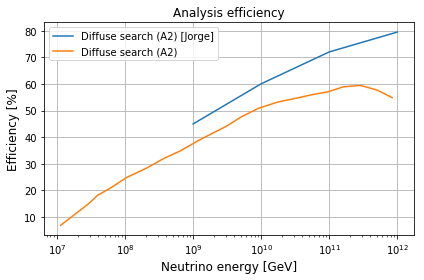

In [42]:
plt.plot(forEff.index/1E9, 100*forEff.passesCuts/forEff.energy, label = "Diffuse search (A2) [Jorge]")
plt.plot(diffuseEff.energy, 100*diffuseEff[" eff"], label = "Diffuse search (A2)")

plt.xscale('log')
plt.xlabel("Neutrino energy [GeV]", fontsize=12)
plt.ylabel("Efficiency [%]", fontsize=12)
plt.title("Analysis efficiency")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/CenA_search_efficiency.png", dpi=200)

#### Put cut line in the SNR vs $C_{sky}$ plot

In [69]:
m = -2080
y = np.linspace(0,1,50);
interc = 20.6-0.54
interc2 = 20.6

x = m*y+interc
x2 = m*y+interc2

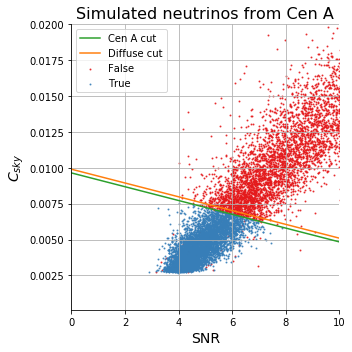

In [70]:
# sns.catplot(x="snr", y="corr", data=df2, hue='failsRcut');
sns.lmplot( x="snr", y="corr", data=cuts, fit_reg=False, hue='failsCut', legend=True, palette="Set1", legend_out=False, scatter_kws={"s": 1})
plt.plot(x,y, color="C2", label = "Cen A cut")
plt.plot(x2,y, color="C1", label = "Diffuse cut")


plt.xlabel("SNR", fontsize=14)
plt.ylabel("$C_{sky}$", fontsize=14)
# plt.xscale('log')
# plt.xscale('log')

plt.xlim(0,10)
plt.ylim(1e-4,0.02)
plt.grid()
plt.grid(which='minor', axis='both')
plt.title("Simulated neutrinos from Cen A", fontsize=16)
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/SNRvsCsky_CenA.png", dpi=200)


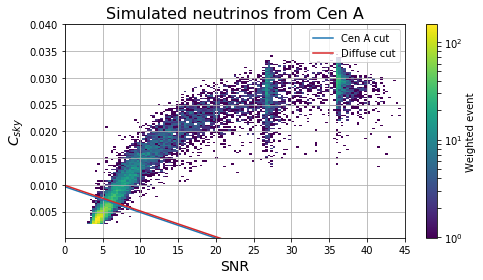

In [71]:
plt.figure(figsize=(7,4))
plt.hist2d(snr_val,corr_val, bins=120, weights=weight,norm=LogNorm());

# plt.hist2d(snr_val,corr_val, bins=420, weights=weight,norm=LogNorm());

plt.colorbar(label="Weighted event" )
plt.xlabel("SNR", fontsize=14)
plt.ylabel("$C_{sky}$", fontsize=14)
# plt.xscale('log')
# plt.xscale('log')
plt.plot(x,y, color="C0", label = "Cen A cut")
plt.plot(x2,y, color="C3", label = "Diffuse cut")

plt.xlim(0,45)
plt.ylim(1e-4,0.04)
plt.grid()
plt.grid(which='minor', axis='both')
plt.legend()
plt.title("Simulated neutrinos from Cen A", fontsize=16)
plt.tight_layout()
# plt.savefig("./plots/SNRvsCsky_CenADiffuse.png", dpi=200)

## Comments